In [1]:
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from Common_codes import correlation_functions_file_20_3_25 as cff
# from Common_codes import evolution_video_creator as evc
from Common_codes import generic_codes_20_3_25 as gc    
from Common_codes import class_defn_file_20_3_25 as cdf
# from Common_codes import evolution_video_creator as evc
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from Common_codes import hamiltonian_derivative_matrices_20_3_25 as hdm

In [3]:
def function_to_create_1D_video(data:np.ndarray,filename,time_data=None)->None:

    # Step 1: Set up the figure, axis, and initial pcolormesh plot
    fig, ax = plt.subplots()

    # Initial pcolormesh plot
    line, = ax.plot(data[0, :])

    # Step 2: Define the update function for each frame
    def update(frame):
        line.set_ydata(data[frame, :])  # Update the mesh data for the current frame
        # ax.set_title(f"Time Step {frame}")
        if(time_data is not None):
            ax.set_title(f"Time Step {time_data[frame]}")
        if(time_data is None):
            ax.set_title(f"Time Step {frame}")
            
        ax.set_ylim(min(data[frame, :]), max(data[frame, :]))
        return line,

    # Step 3: Create the animation
    ani = FuncAnimation(fig, update,frames = data.shape[0])

    # Step 4: Save or display the animation
    ani.save(filename+'.mp4', writer='ffmpeg', fps=10)  
    return    
  
def function_to_create_2D_video(data,square_size:int,filename,time_data=None)->None:
    # Step 1: Set up the figure, axis, and initial pcolormesh plot
    fig, ax = plt.subplots()

    # Initial pcolormesh plot
    mesh = ax.pcolormesh(np.reshape(data[0, :],(square_size,square_size)), shading='auto', cmap='viridis')

    norm = Normalize(vmin=np.min(data[0,:]), vmax=np.max(data[0,:]))
    # Add a color bar to show the data range
    cbar = plt.colorbar(mesh, ax=ax, norm = norm)

    # Step 2: Define the update function for each frame
    def update(frame):
        mesh.set_array(data[frame, :])  # Update the mesh data for the current frame
        # ax.set_title(f"Time Step {frame}")
        
        if(time_data is not None):
            ax.set_title(f"Time Step {time_data[frame]}")
        if(time_data is None):
            ax.set_title(f"Time Step {frame}")

        norm = Normalize(vmin=np.min(data[frame,:]), vmax=np.max(data[frame,:]))
        mesh.set_norm(norm)
        cbar.update_normal(mesh)
        return mesh,

    # Step 3: Create the animation
    ani = FuncAnimation(fig, update,frames = data.shape[0])

    # Step 4: Save or display the animation
    ani.save(filename+'.mp4', writer='ffmpeg', fps=10) 
    return       

def function_to_extract_SC_order_parameter_complete(delta_r_complete:np.ndarray,Gamma_b_complete:np.ndarray,Gamma_m_complete:np.ndarray,
                                                    lmbda_complete:np.ndarray,
                                                initial_input_variables:cdf.input_variables):
    
    N_b = initial_input_variables.N_b
    N_f = initial_input_variables.N_f
    N_f_spinless = int(N_f/2)
    fourier_transform_matrix = initial_input_variables.fourier_array
    sc_order_parameter_fourier_space_complete = np.zeros((Gamma_m_complete.shape[0],N_b),dtype=np.complex128)

    for time in range(Gamma_m_complete.shape[0]):
        Gamma_m = torch.tensor(np.reshape(Gamma_m_complete[time,:],(2*N_f,2*N_f)),dtype=torch.complex128)
        Gamma_b = torch.tensor(np.reshape(Gamma_b_complete[time,:],(2*N_b,2*N_b)),dtype=torch.complex128)
        delta_r = torch.tensor(np.reshape(delta_r_complete[time,:],(2*N_b,)),dtype=torch.complex128)
        lmbda = torch.tensor(np.reshape(lmbda_complete[time,:],(N_b,N_f)),dtype=torch.complex128)


        initial_input_variables.updating_lambda(lmbda) 

        # Creating the computed variables instance
        computed_variables_instance = cdf.computed_variables(N_b,N_f)

        # Computing the values for the computed_varaibles class
        computed_variables_instance.initialize_all_variables(initial_input_variables,delta_r,Gamma_b)

        fermionic_correlations = cff.correlation_functions(Gamma_m,N_f)

        sc_order_parameter_real_space = hdm.Delta_for_h_m(delta_r = delta_r,Gamma_b=Gamma_b, Gamma_m=Gamma_m,input_variables = initial_input_variables,
                                                        computed_variables= computed_variables_instance,correlation_matrices=fermionic_correlations)

        sc_order_parameter_fouier_space = 1/N_b*torch.einsum('kn,km,nm -> k',fourier_transform_matrix[:,0:N_f_spinless],torch.conj(fourier_transform_matrix[:,0:N_f_spinless]),sc_order_parameter_real_space[0:N_f_spinless,N_f_spinless:])
        # print(sc_order_parameter_fouier_space.shape)
        sc_order_parameter_fourier_space_complete[time,:] = np.array(sc_order_parameter_fouier_space)
    return sc_order_parameter_fourier_space_complete

def function_to_extract_c_dagger_c_data_complete(Gamma_m_complete:np.ndarray,N_f):
    
    c_dagger_c_data_complete = np.zeros((Gamma_m_complete.shape[0],N_f*N_f),dtype=np.complex128)
    
    for time in range(Gamma_m_complete.shape[0]):
        Gamma_m = torch.tensor(np.reshape(Gamma_m_complete[time,:],(2*N_f,2*N_f)),dtype=torch.complex128)

        fermionic_correlations = cff.correlation_functions(Gamma_m,N_f)

        c_dagger_c_data_complete[time,:] = np.array(fermionic_correlations.c_dagger_c_mat).flatten()
    
    return c_dagger_c_data_complete

def function_to_extract_c_c_data_complete(Gamma_m_complete:np.ndarray,N_f):
    
    c_dagger_c_data_complete = np.zeros((Gamma_m_complete.shape[0],N_f*N_f),dtype=np.complex128)
    
    for time in range(Gamma_m_complete.shape[0]):
        Gamma_m = torch.tensor(np.reshape(Gamma_m_complete[time,:],(2*N_f,2*N_f)),dtype=torch.complex128)

        fermionic_correlations = cff.correlation_functions(Gamma_m,N_f)

        c_dagger_c_data_complete[time,:] = np.array(fermionic_correlations.c_c_mat).flatten()
    
    return c_dagger_c_data_complete

def function_to_create_2D_video_colorbar_fixed(data,square_size:int,filename,time_data=None)->None:
    # Step 1: Set up the figure, axis, and initial pcolormesh plot
    fig, ax = plt.subplots()

    # Initial pcolormesh plot
    mesh = ax.pcolormesh(np.reshape(data[0, :],(square_size,square_size)), shading='auto', cmap='viridis',
                         vmin=np.min(data[0,:]), vmax=np.max(data[0,:]))

    # Add a color bar to show the data range
    cbar = plt.colorbar(mesh, ax=ax)

    # Step 2: Define the update function for each frame
    def update(frame):
        mesh.set_array(data[frame, :])  # Update the mesh data for the current frame
        # ax.set_title(f"Time Step {frame}")
        
        if(time_data is not None):
            ax.set_title(f"Time Step {time_data[frame]}")
        if(time_data is None):
            ax.set_title(f"Time Step {frame}")
        return mesh,

    # Step 3: Create the animation
    ani = FuncAnimation(fig, update,frames = data.shape[0])

    # Step 4: Save or display the animation
    ani.save(filename+'.mp4', writer='ffmpeg', fps=10) 
    return       


In [4]:
base_path = os.getcwd()
complete_path = base_path+'/'
###########################################################
###########################################################
# from Common_codes.class_defn_file_20_3_25 import input_variables


number_of_points = 10
positon_value_max = [10 , 10]
positon_value_min = [0  , 0]
position_space_grid = gc.coordinate_array_creator_function(positon_value_min,positon_value_max,number_of_points,True)
position_space_grid_tensor = torch.tensor(position_space_grid)

N_f = np.shape(position_space_grid)[0]
print("Position space grid created")

momentum_value_max = [np.pi/(positon_value_max[0]-positon_value_min[0])*number_of_points ,np.pi/(positon_value_max[1]-positon_value_min[1])*number_of_points]
momentum_value_min = [-np.pi/(positon_value_max[0]-positon_value_min[0])*number_of_points ,-np.pi/(positon_value_max[1]-positon_value_min[1])*number_of_points]
momentum_space_grid = gc.coordinate_array_creator_function(momentum_value_min,momentum_value_max,number_of_points,False)
momentum_space_grid_tensor = torch.tensor(momentum_space_grid)

N_b = np.shape(momentum_space_grid)[0]
print("Momentum space grid created")

boson_space_grid = gc.coordinate_array_creator_function(positon_value_min,positon_value_max,number_of_points,False)
boson_space_grid_tensor = torch.tensor(boson_space_grid)
fourier_transform_matrix = torch.tensor(gc.creating_fourier_matrix(momentum_space_grid,position_space_grid))

volume = np.prod(np.array(positon_value_max)-np.array(positon_value_min))

###########################################################
###########################################################

momentum_space_mesh = np.meshgrid(np.linspace(momentum_value_min[0],momentum_value_max[0],number_of_points,endpoint=False),np.linspace(momentum_value_min[1],momentum_value_max[1],number_of_points,endpoint=False))


###########################################################
###########################################################

J_0 = -1
J_0_matrix = gc.creating_J_0_matrix(position_space_grid,J_0,positon_value_max[0],spin_index=True)
J_0_tensor = torch.tensor(J_0_matrix,dtype=torch.complex128)


# J_0_matrix = np.diag(np.ones(N_f)*J_0,1) + np.diag(np.ones(N_f)*J_0,-1)
omega_0 = 10*np.abs(J_0)
omega = omega_0*np.abs(J_0)*np.identity(N_b)
omega_tensor = torch.tensor(omega,dtype=torch.complex128)


gamma_0 = 0.5*omega_0
gamma = gamma_0*np.append(np.identity(N_b),np.identity(N_b),axis = 1)
gamma_tensor = torch.tensor(gamma,dtype=torch.complex128)

chemical_potential_val = -4.9
###########################################################
###########################################################
delta_r_complete = np.load(complete_path+"imag_time_evo_delta_r_complete_mu_-4.9_t_100.npy")
print("delta_r complete data extracted")


gamma_b_complete = np.load(complete_path+"imag_time_evo_gamma_b_complete_mu_-4.9_t_100.npy")
print("gamma_b complete data extracted")

gamma_m_complete = np.load(complete_path+"imag_time_evo_gamma_m_complete_mu_-4.9_t_100.npy")
print("gamma_m complete data extracted")

lmbda_complete = np.load(complete_path+"imag_time_evo_lambda_complete_mu_-4.9_t_100.npy")
print("lambda complete data extracted")
###########################################################
###########################################################
lmbda_initial = torch.tensor(np.reshape(lmbda_complete[0,:],(N_b,N_f)),dtype=torch.complex128)
initial_input_variables = cdf.input_variables(position_space_grid_tensor,boson_space_grid_tensor,fourier_transform_matrix,lmbda_initial,J_0_tensor,gamma_tensor,omega_tensor,chemical_potential_val)

print("Initial input variables class created")
###########################################################
###########################################################

# Extracting the c dagger c data
c_dagger_c_data_complete = function_to_extract_c_dagger_c_data_complete(gamma_m_complete,initial_input_variables.N_f)
print("c_dagger c data extracted")

# Extracting the Superconductor order parameter
sc_order_parameter_fourier_space_complete = function_to_extract_SC_order_parameter_complete(delta_r_complete,gamma_b_complete,gamma_m_complete,
                                                lmbda_complete,initial_input_variables)
print("SC order parameter (fourier space) extracted")
###########################################################
###########################################################
print("All matrices created and computed")

Position space grid created
Momentum space grid created
delta_r complete data extracted
gamma_b complete data extracted
gamma_m complete data extracted
lambda complete data extracted
Initial input variables class created
c_dagger c data extracted
SC order parameter (fourier space) extracted
All matrices created and computed


In [17]:
time_data = np.load(complete_path+"time_data.npy")
def finding_average_order_parameter_values(sc_order_parameter,c_dagger_c_data,time_data,N_f):
    average_sc_order_parameter = np.zeros(time_data.shape[0])
    average_CDW_order_parameter = np.zeros(time_data.shape[0])
    N_f_spinless = int(N_f/2)
    variance_in_cdw_order_parameter = np.zeros(time_data.shape[0])
    for i in range(time_data.shape[0]):
        # computing average SC order parameter in Fourier space
        average_sc_order_parameter[i] = np.mean(np.abs(sc_order_parameter[i,:]))
        
        # computing average CDW order parameter
        c_dagger_c_diagonal = np.diag(np.reshape(c_dagger_c_data[i, :], (N_f, N_f))[0:N_f_spinless,0:N_f_spinless]).real
        average_density = np.mean(c_dagger_c_diagonal)
        fluctuation = c_dagger_c_diagonal - average_density
        average_CDW_order_parameter[i] = np.mean(np.abs(fluctuation)) 
        variance_in_cdw_order_parameter[i] = np.var(np.abs(fluctuation))

    return(average_sc_order_parameter, average_CDW_order_parameter,variance_in_cdw_order_parameter)

# function_to_create_2D_video(np.abs(sc_order_parameter_fourier_space_complete), 10, complete_path+"sc_order_fourier_space_t_20",time_data)
average_sc_order_parameter, average_CDW_order_parameter,variance_in_cdw_order_parameter = finding_average_order_parameter_values(sc_order_parameter_fourier_space_complete,c_dagger_c_data_complete,time_data,N_f)


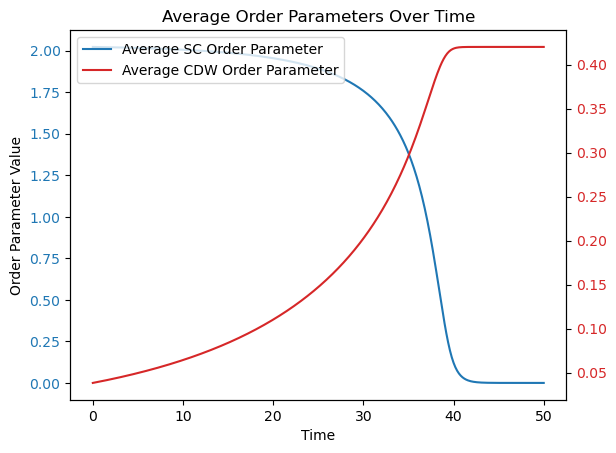

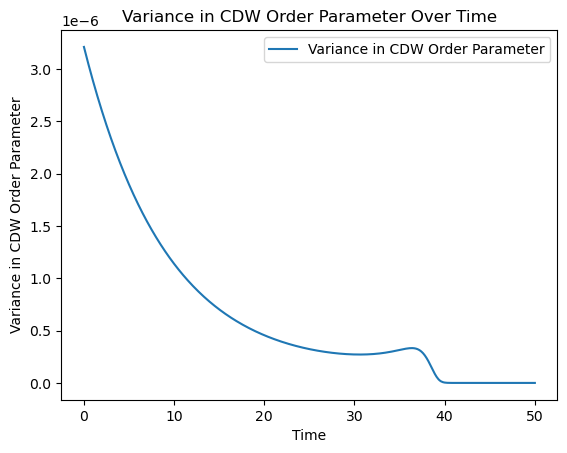

In [23]:
fig, ax1 = plt.subplots()  
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

l1 = ax1.plot(time_data, average_sc_order_parameter, label='Average SC Order Parameter',color='tab:blue')
l2 = ax2.plot(time_data, average_CDW_order_parameter, label='Average CDW Order Parameter',color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax1.set_xlabel('Time')
ax1.set_ylabel('Order Parameter Value')
ax1.set_title('Average Order Parameters Over Time')
lns = l1 + l2  # Combine the two lists of lines
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc ='upper left')
plt.show()

plt.plot(time_data, variance_in_cdw_order_parameter, label='Variance in CDW Order Parameter')
plt.xlabel('Time')
plt.ylabel('Variance in CDW Order Parameter')
plt.title('Variance in CDW Order Parameter Over Time')
plt.legend()
plt.show()


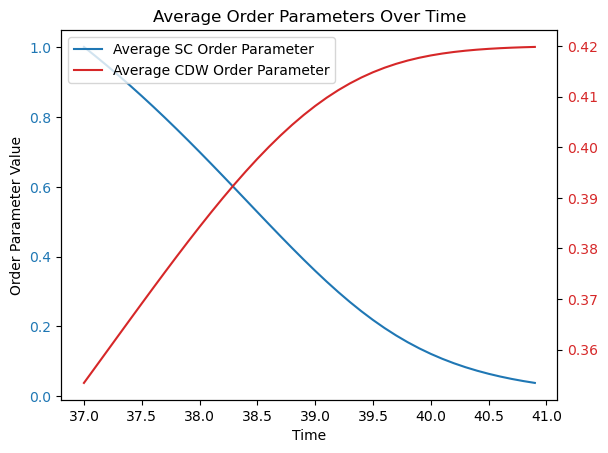

In [28]:
fig, ax1 = plt.subplots()  
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

l1 = ax1.plot(time_data[370:410], average_sc_order_parameter[370:410], label='Average SC Order Parameter',color='tab:blue')
l2 = ax2.plot(time_data[370:410], average_CDW_order_parameter[370:410], label='Average CDW Order Parameter',color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax1.set_xlabel('Time')
ax1.set_ylabel('Order Parameter Value')
ax1.set_title('Average Order Parameters Over Time')
lns = l1 + l2  # Combine the two lists of lines
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc ='upper left')
plt.show()


In [24]:
time_index

390

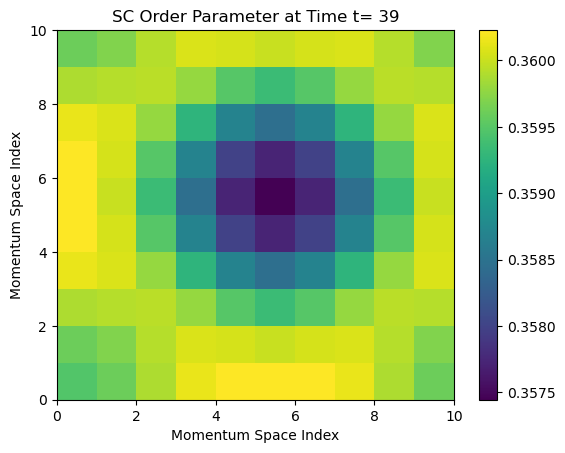

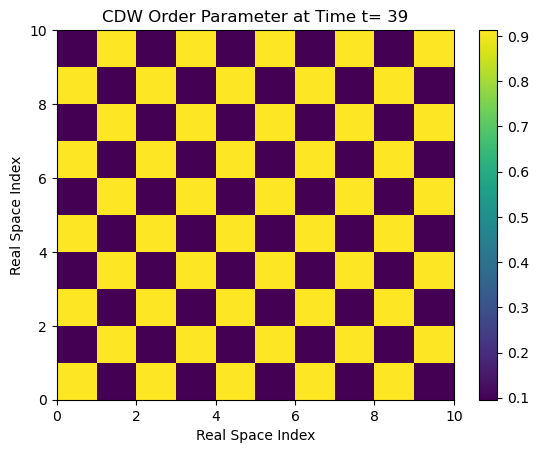

In [23]:
time_data = np.load(complete_path+"time_data.npy")

t = 39
time_index = np.where(time_data==t)[0][0]

# Superconucting order parameter for a given time
plt.pcolormesh(np.reshape(np.abs(sc_order_parameter_fourier_space_complete[time_index,:]),(10,10)), shading='auto', cmap='viridis')
plt.colorbar()
plt.title(f"SC Order Parameter at Time t= {t}")
plt.xlabel('Momentum Space Index')
plt.ylabel('Momentum Space Index')
plt.show()

# CDW order parameter for a given time
N_f_spinless = int(N_f/2)
plt.pcolormesh(np.reshape(c_dagger_c_data_complete[time_index,:],(N_f,N_f)).diagonal().real[0:N_f_spinless].reshape((10,10)), shading='auto', cmap='viridis')
# plt.pcolormesh(np.reshape(np.diag(c_dagger_c_data_complete[time_index,:].real[0:N_f_spinless]),(10,10)), shading='auto', cmap='viridis')
plt.colorbar()
plt.title(f"CDW Order Parameter at Time t= {t}")
plt.xlabel('Real Space Index')
plt.ylabel('Real Space Index')
plt.show()


In [22]:
time_index[0]

390

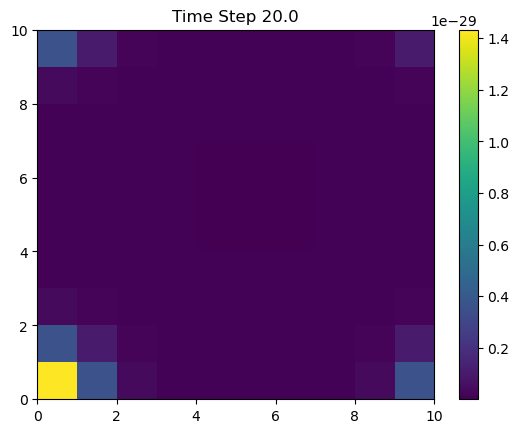

In [39]:
# Plotting the sc order parameter
def function_to_create_2D_video_colorbar_fixed_2(data,square_size:int,filename,time_data=None)->None:
    # Step 1: Set up the figure, axis, and initial pcolormesh plot
    fig, ax = plt.subplots()

    # Initial pcolormesh plot
    mesh = ax.pcolormesh(np.reshape(data[0, :],(square_size,square_size)), shading='auto', cmap='viridis',
                         vmin=np.min(data), vmax=np.max(data))

    # Add a color bar to show the data range
    cbar = plt.colorbar(mesh, ax=ax)

    # Step 2: Define the update function for each frame
    def update(frame):
        mesh.set_array(data[frame, :])  # Update the mesh data for the current frame
        # ax.set_title(f"Time Step {frame}")
        
        if(time_data is not None):
            ax.set_title(f"Time Step {time_data[frame]}")
        if(time_data is None):
            ax.set_title(f"Time Step {frame}")
        return mesh,

    # Step 3: Create the animation
    ani = FuncAnimation(fig, update,frames = data.shape[0])

    # Step 4: Save or display the animation
    ani.save(filename+'.mp4', writer='ffmpeg', fps=10) 
    return       

time_data = np.load(complete_path + "time_data.npy")
# time_data = np.linspace(0,50,delta_r_complete.shape[0])

# function_to_create_2D_video(np.abs(sc_order_parameter_fourier_space_complete), 10, complete_path+"sc_order_fourier_space_t_20",time_data)
function_to_create_2D_video_colorbar_fixed_2(np.abs(sc_order_parameter_fourier_space_complete), 10,complete_path +"sc_order_fourier_space_cbar_fixed_t_20",time_data)

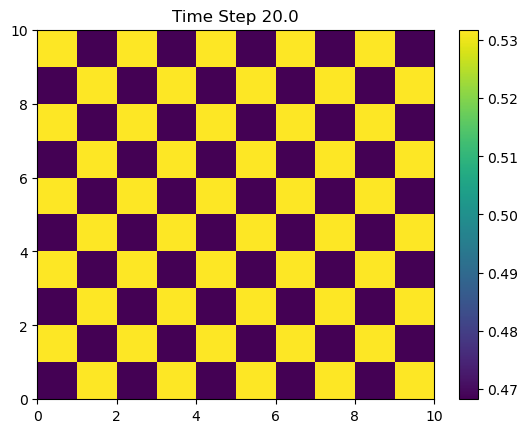

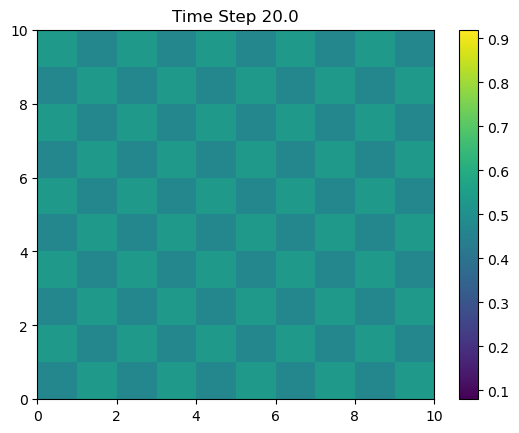

In [40]:
# Extracting and plotting the CDW order parameter order parameter

# time_data = np.load(complete_path+ "time_data.npy")

def extracting_diagonal_c_dagger_c(c_dagger_c_data_complete,N_f):
    N_f_spinless = int(N_f/2) 
    diagonal_data = np.zeros((c_dagger_c_data_complete.shape[0], N_f_spinless), dtype=np.float64)
    for time in range(c_dagger_c_data_complete.shape[0]):
        diagonal_data[time, :] = np.diag(np.reshape(c_dagger_c_data_complete[time, :], (N_f, N_f))[0:N_f_spinless,0:N_f_spinless]).real
    return diagonal_data

diagonal_data = extracting_diagonal_c_dagger_c(c_dagger_c_data_complete,initial_input_variables.N_f)
function_to_create_2D_video(diagonal_data, 10,complete_path + "CDW_order_t_20",time_data)
function_to_create_2D_video_colorbar_fixed(diagonal_data, 10,complete_path + "CDW_order_mu_cbar_fixed_t_20",time_data)


In [41]:
# time_data = np.load(complete_path+"time_data.npy")

def energy_expectation_value(delta_r_tensor:torch.Tensor,Gamma_b_tensor:torch.Tensor,Gamma_m_tensor:torch.Tensor,
                            input_variables:cdf.input_variables,
                            computed_variables:cdf.computed_variables,
                            correlation_matrices:cff.correlation_functions):
    J_i_j_matrix = computed_variables.J_i_j_mat
    Ve_i_J_matrix = computed_variables.Ve_i_j_mat
    delta_gamma_tilde_matrix = computed_variables.delta_gamma_tilde_mat
    omega_bar_matrix = computed_variables.omega_bar_mat
    chemical_potential = torch.diag( computed_variables.chemical_potential(input_variables) )

    if(delta_r_tensor.dtype != torch.complex128):
        raise Exception("The delta_r_tensor is not a complex numpy array. Please check the computation of the energy expectation value.")
    if(Gamma_b_tensor.dtype != torch.complex128):
        raise Exception("Gamma_b is not a complex numpy array. Please check the computation of the energy expectation value.")

    # Correlation matrix creation functions (assumed to be globally stored from now on)
    c_dagger_c_mat = correlation_matrices.c_dagger_c_mat
    c_dagger_c_dagger_mat = correlation_matrices.c_dagger_c_dagger_mat
    c_c_mat = correlation_matrices.c_c_mat

    phonon_energy = 1/4.0* torch.einsum('i,ij,j->',delta_r_tensor,omega_bar_matrix,delta_r_tensor) + 1/4.0*torch.trace(omega_bar_matrix@Gamma_b_tensor)- 1/4.0 *torch.sum(torch.diag(omega_bar_matrix)) 

    electron_kinetic_energy = (torch.einsum('ij,ij->',J_i_j_matrix,c_dagger_c_mat) - torch.einsum('i,ii->',chemical_potential, c_dagger_c_mat) )
    
    electron_electron_interaction_energy = (0.5*torch.einsum('ij,ii,jj->',Ve_i_J_matrix,c_dagger_c_mat,c_dagger_c_mat)
                                            - 0.5*torch.einsum('ij,ij,ji->',Ve_i_J_matrix,c_dagger_c_mat,c_dagger_c_mat)
                                            + 0.5*torch.einsum('ij,ij,ji->',Ve_i_J_matrix,c_dagger_c_dagger_mat,c_c_mat))
    
    electron_phonon_interaction_energy = torch.einsum('ki,k,i->',delta_gamma_tilde_matrix,delta_r_tensor,torch.diag(c_dagger_c_mat)) 

    # Computing of the energy expectation value
    # val = (torch.einsum('ij,ij->',J_i_j_matrix,c_dagger_c_mat) - torch.einsum('i,ii->',chemical_potential, c_dagger_c_mat) 
    #        + 1/4.0* torch.einsum('i,ij,j->',delta_r_tensor,omega_bar_matrix,delta_r_tensor) + 1/4.0*torch.trace(omega_bar_matrix@Gamma_b_tensor)
    #        + torch.einsum('ki,k,i->',delta_gamma_tilde_matrix,delta_r_tensor,torch.diag(c_dagger_c_mat)) 
    #        + 0.5*torch.einsum('ij,ii,jj->',Ve_i_J_matrix,c_dagger_c_mat,c_dagger_c_mat)
    #        - 0.5*torch.einsum('ij,ij,ji->',Ve_i_J_matrix,c_dagger_c_mat,c_dagger_c_mat)
    #        + 0.5*torch.einsum('ij,ij,ji->',Ve_i_J_matrix,c_dagger_c_dagger_mat,c_c_mat)
    #        - 1/4.0 *torch.sum(torch.diag(omega_bar_matrix))     # This is the constant energy shift term. However, it becomes essential to get this correct for the phase shift and hence check this once again
    #        )
    val = phonon_energy + electron_kinetic_energy + electron_electron_interaction_energy + electron_phonon_interaction_energy

    if(val.shape == (1,)):
        raise Exception("The energy expectation value is not a single value. Please check the computation of the energy expectation value.")
    
    return([val,phonon_energy,electron_kinetic_energy,electron_electron_interaction_energy,electron_phonon_interaction_energy])

def function_to_extract_all_energies(delta_r_complete,gamma_b_complete,gamma_m_complete,lambda_complete,
                                     initial_input_variables:cdf.input_variables):
    N_b = initial_input_variables.N_b
    N_f = initial_input_variables.N_f

    total_energy_mat = torch.zeros((gamma_m_complete.shape[0],),dtype=torch.complex128)
    phonon_energy_mat = torch.zeros((gamma_m_complete.shape[0],),dtype=torch.complex128)
    electron_kinetic_energy_mat = torch.zeros((gamma_m_complete.shape[0],),dtype=torch.complex128)
    electron_electron_interaction_energy_mat = torch.zeros((gamma_m_complete.shape[0],),dtype=torch.complex128)
    electron_phonon_interaction_energy_mat = torch.zeros((gamma_m_complete.shape[0],),dtype=torch.complex128)

    for i in range(gamma_m_complete.shape[0]):
        gamma_m = torch.tensor(np.reshape(gamma_m_complete[i,:],(2*N_f,2*N_f)),dtype=torch.complex128)
        gamma_b = torch.tensor(np.reshape(gamma_b_complete[i,:],(2*N_b,2*N_b)),dtype=torch.complex128)
        delta_r = torch.tensor(np.reshape(delta_r_complete[i,:],(2*N_b,)),dtype=torch.complex128)
        lambda_ = torch.tensor(np.reshape(lambda_complete[i,:],(N_b,N_f)),dtype=torch.complex128)

        initial_input_variables.updating_lambda(lambda_)
        computed_variables_instance = cdf.computed_variables(N_b,N_f)
        computed_variables_instance.initialize_all_variables(initial_input_variables,delta_r,gamma_b)

        fermionic_correlations = cff.correlation_functions(gamma_m,N_f)

        result = energy_expectation_value(delta_r,gamma_b,gamma_m,initial_input_variables,computed_variables_instance,fermionic_correlations)
        total_energy_mat[i] = result[0]
        phonon_energy_mat[i] = result[1]
        electron_kinetic_energy_mat[i] = result[2]
        electron_electron_interaction_energy_mat[i] = result[3]
        electron_phonon_interaction_energy_mat[i] = result[4]
    return([total_energy_mat,phonon_energy_mat,electron_kinetic_energy_mat,electron_electron_interaction_energy_mat,electron_phonon_interaction_energy_mat])        

total_energy_mat,phonon_energy_mat,electron_kinetic_energy_mat,electron_electron_interaction_energy_mat,electron_phonon_interaction_energy_mat= function_to_extract_all_energies(delta_r_complete,gamma_b_complete,gamma_m_complete,lmbda_complete,
                                     initial_input_variables)

# plt.plot(time_data,total_energy_mat.real,color='black',linewidth=2,label='Total Energy')
# plt.plot(time_data,phonon_energy_mat.real,color='red',linewidth=2,label='Phonon Energy')
# plt.plot(time_data,electron_kinetic_energy_mat.real,color='blue',linewidth=2,label='Electron Kinetic Energy')
# plt.plot(time_data,electron_electron_interaction_energy_mat.real,color='green',linewidth=2,label='Electron Electron Interaction Energy')
# plt.plot(time_data,electron_phonon_interaction_energy_mat.real,color='orange',linewidth=2,label='Electron Phonon Interaction Energy')
# plt.legend()
# plt.xlabel("Time")
# plt.ylabel("Energy")
# plt.grid()
# plt.title("Energy variation with time")
# plt.show()

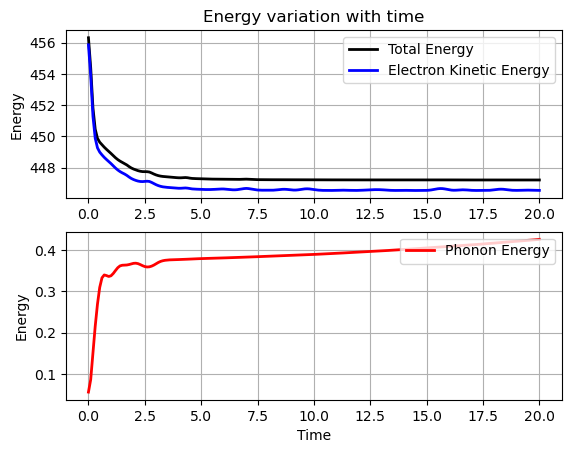

In [42]:
time_data = np.load(complete_path+ "time_data.npy")

fig, ax = plt.subplots(2,1)
ax[0].plot(time_data,total_energy_mat.real,color='black',linewidth=2,label='Total Energy')
ax[0].plot(time_data,electron_kinetic_energy_mat.real,color='blue',linewidth=2,label='Electron Kinetic Energy')
ax[0].legend(loc='upper right')
ax[0].set_ylabel("Energy")
ax[0].grid()
ax[0].set_title("Energy variation with time")
# title("Energy variation with time")

ax[1].plot(time_data,phonon_energy_mat.real,color='red',linewidth=2,label='Phonon Energy')
# ax[1].plot(time_data,electron_electron_interaction_energy_mat.real,color='green',linewidth=2,label='Electron Electron Interaction Energy')
# ax[1].plot(time_data,electron_phonon_interaction_energy_mat.real,color='orange',linewidth=2,label='Electron Phonon Interaction Energy')
ax[1].legend(loc='upper right')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Energy")
ax[1].grid()
plt.savefig(complete_path+"energy_variation_with_time_t_20.pdf", format="pdf", bbox_inches="tight")
plt.savefig(complete_path+"energy_variation_with_time_t_20.png")
plt.show()


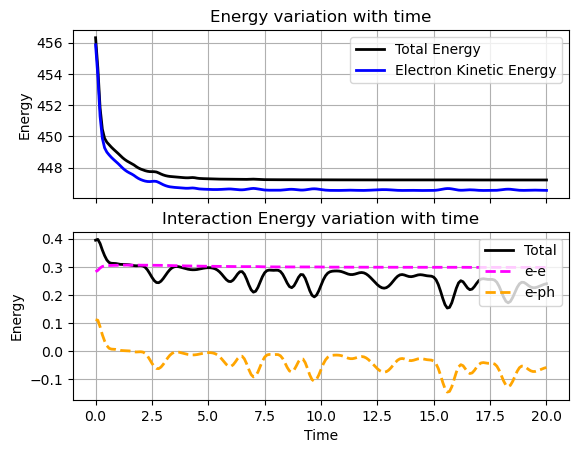

In [43]:
fig, ax = plt.subplots(2,1)
ax[0].plot(time_data,total_energy_mat.real,color='black',linewidth=2,label='Total Energy')
ax[0].plot(time_data,electron_kinetic_energy_mat.real,color='blue',linewidth=2,label='Electron Kinetic Energy')
ax[0].legend(loc='upper right')
ax[0].set_ylabel("Energy")
ax[0].grid()
ax[0].set_xticklabels([])
ax[0].set_title("Energy variation with time")
# title("Energy variation with time")

# ax[1].plot(time_data,phonon_energy_mat.real,color='red',linewidth=2,label='Phonon Energy')
ax[1].plot(time_data,electron_electron_interaction_energy_mat.real+electron_phonon_interaction_energy_mat.real,
           color='black',linewidth=2,label='Total')
ax[1].plot(time_data,electron_electron_interaction_energy_mat.real,color='magenta',linewidth=2,label='e-e',
           linestyle='dashed')
ax[1].plot(time_data,electron_phonon_interaction_energy_mat.real,color='orange',linewidth=2,label='e-ph',
           linestyle='dashed')
ax[1].legend(loc='upper right')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Energy")
ax[1].set_title("Interaction Energy variation with time")
ax[1].grid()
plt.savefig(complete_path+"interaction_energy_with_time_t_20.pdf", format="pdf", bbox_inches="tight")
plt.savefig(complete_path+"interaction_energy_with_time_t_20.png")

# plt.savefig(complete_path+"energy_variation_with_time_mu_ini_-5.1_mu_final_-5.5_t_20.pdf", format="pdf", bbox_inches="tight")
plt.show()

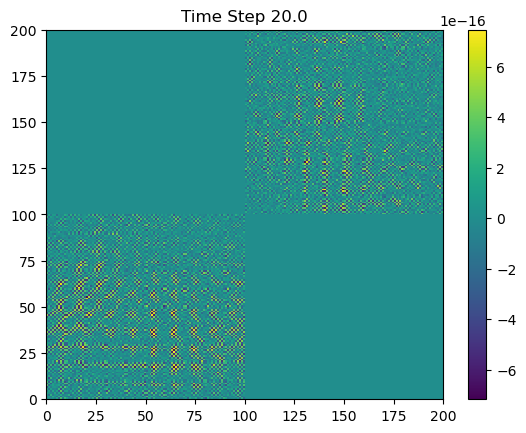

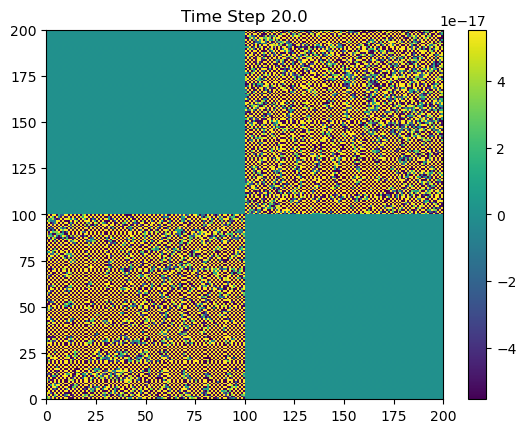

In [44]:
# Extracting c_c_data complete
# time_data = np.load(complete_path + "time_data.npy") 

def extracting_diagonal_c_c(c_dagger_c_data_complete,N_f):
    N_f_spinless = int(N_f/2) 
    diagonal_data = np.zeros((c_dagger_c_data_complete.shape[0], N_f_spinless), dtype=np.float64)
    for time in range(c_dagger_c_data_complete.shape[0]):
        diagonal_data[time, :] = np.diag(np.reshape(c_dagger_c_data_complete[time, :], (N_f, N_f))[0:N_f_spinless,N_f_spinless:]).real
    return diagonal_data

c_c_data_complete = function_to_extract_c_c_data_complete(gamma_m_complete,initial_input_variables.N_f)

# diagonal_data = extracting_diagonal_c_c(c_c_data_complete,initial_input_variables.N_f)
function_to_create_2D_video(c_c_data_complete.real, 200, complete_path +"c_c_complete_t_20",time_data)
function_to_create_2D_video_colorbar_fixed(c_c_data_complete.real, 200,complete_path + "c_c_complete_cbar_fixed_t_20",time_data)


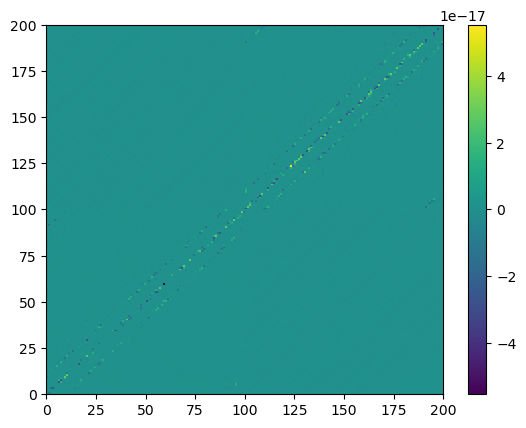

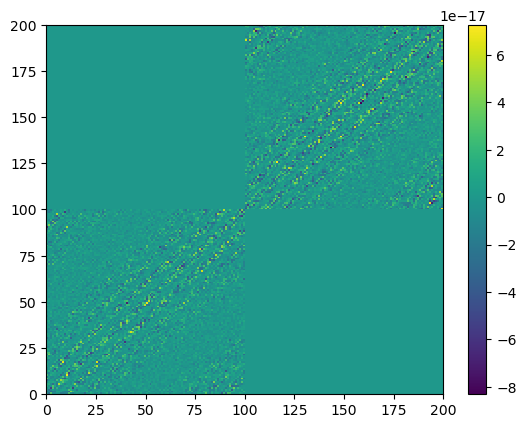

In [45]:
plt.pcolormesh(np.reshape(c_c_data_complete[0,:],(200,200)).real)
plt.colorbar()
plt.show()

plt.pcolormesh(np.reshape(c_c_data_complete[10,:],(200,200)).real)
plt.colorbar()
plt.show()


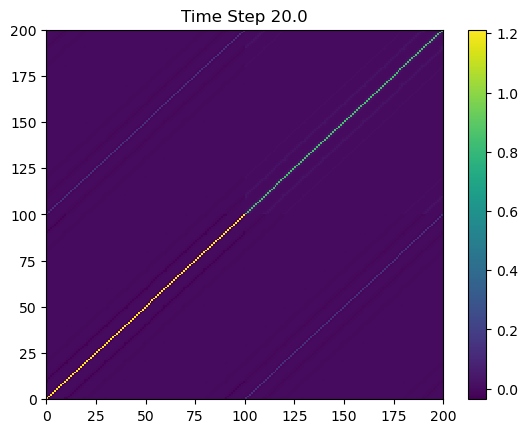

In [46]:
function_to_create_2D_video(gamma_b_complete, 200, complete_path + "gamma_b_complete_t_20",time_data)


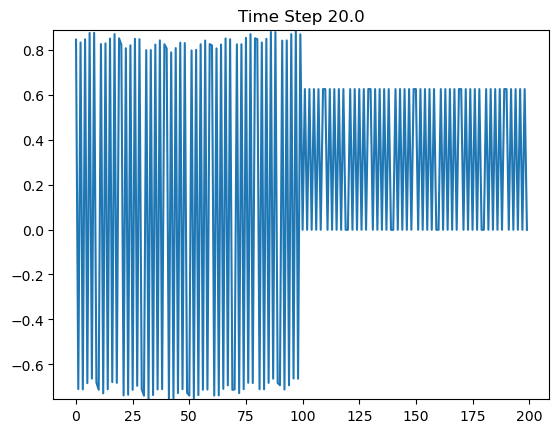

In [47]:
function_to_create_1D_video(delta_r_complete,complete_path + "delta_r_complete_mu_ini_-5.1_mu_final_-5.5_t_20",time_data)

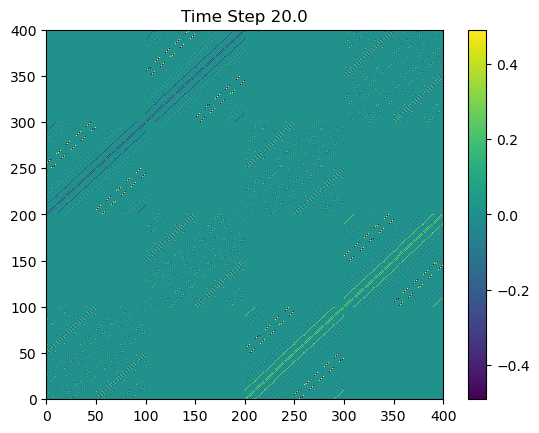

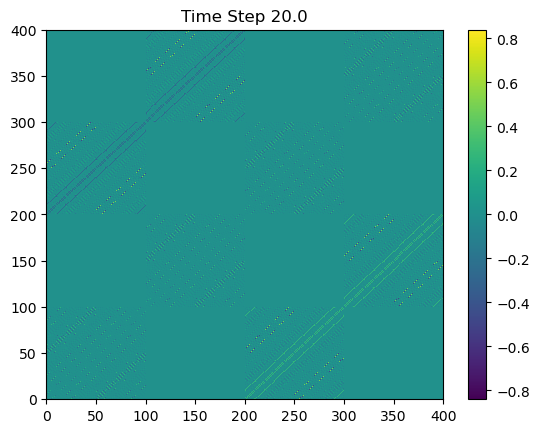

In [48]:
function_to_create_2D_video(gamma_m_complete, 400,complete_path + "gamma_m_complete_mu_ini_t_20",time_data)
function_to_create_2D_video_colorbar_fixed(gamma_m_complete, 400, complete_path+"gamma_m_complete_cbar_fixed_t_20",time_data)

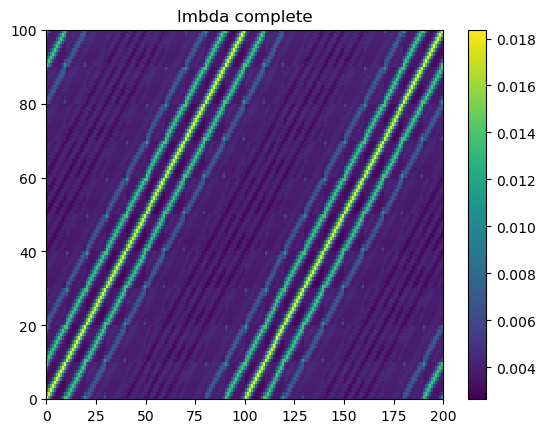

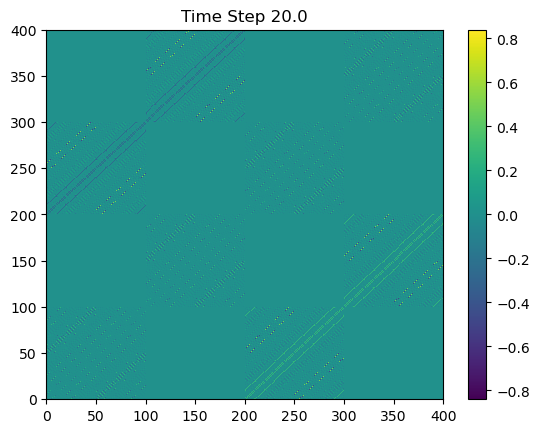

In [49]:
plt.pcolormesh(np.reshape(lmbda_complete[100,:],(N_b,N_f))  )
plt.colorbar()
plt.title("lmbda complete")
plt.show()
function_to_create_2D_video_colorbar_fixed(gamma_m_complete, 400, complete_path+"gamma_m_complete_cbar_fixed_t_20",time_data)

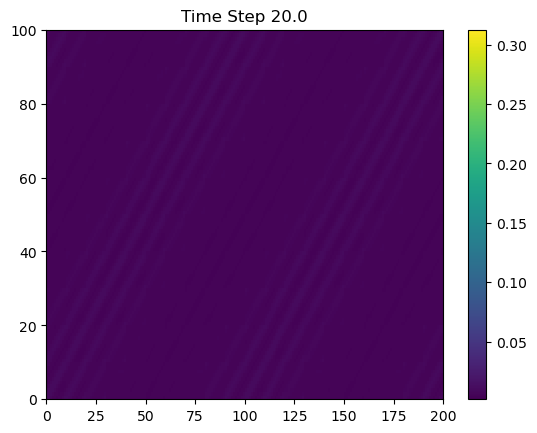

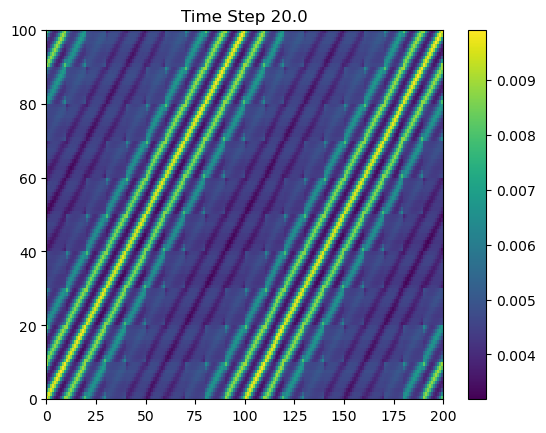

In [50]:
def function_to_create_2D_video_lambda(data,N_b,N_f,filename,time_data=None)->None:
    # Step 1: Set up the figure, axis, and initial pcolormesh plot
    fig, ax = plt.subplots()

    # Initial pcolormesh plot
    mesh = ax.pcolormesh(np.reshape(data[0, :],(N_b,N_f)), shading='auto', cmap='viridis')

    norm = Normalize(vmin=np.min(data[0,:]), vmax=np.max(data[0,:]))
    # Add a color bar to show the data range
    cbar = plt.colorbar(mesh, ax=ax, norm = norm)

    # Step 2: Define the update function for each frame
    def update(frame):
        mesh.set_array(data[frame, :])  # Update the mesh data for the current frame
        # ax.set_title(f"Time Step {frame}")
        
        if(time_data is not None):
            ax.set_title(f"Time Step {time_data[frame]}")
        if(time_data is None):
            ax.set_title(f"Time Step {frame}")

        norm = Normalize(vmin=np.min(data[frame,:]), vmax=np.max(data[frame,:]))
        mesh.set_norm(norm)
        cbar.update_normal(mesh)
        return mesh,

    # Step 3: Create the animation
    ani = FuncAnimation(fig, update,frames = data.shape[0])

    # Step 4: Save or display the animation
    ani.save(filename+'.mp4', writer='ffmpeg', fps=10) 
    return       


def function_to_create_2D_video_colorbar_fixed_lambda(data,N_b,N_f,filename,time_data=None)->None:
    # Step 1: Set up the figure, axis, and initial pcolormesh plot
    fig, ax = plt.subplots()

    # Initial pcolormesh plot
    mesh = ax.pcolormesh(np.reshape(data[0, :],(N_b,N_f)), shading='auto', cmap='viridis',
                         vmin=np.min(data[0,:]), vmax=np.max(data[0,:]))

    # Add a color bar to show the data range
    cbar = plt.colorbar(mesh, ax=ax)

    # Step 2: Define the update function for each frame
    def update(frame):
        mesh.set_array(data[frame, :])  # Update the mesh data for the current frame
        # ax.set_title(f"Time Step {frame}")
        
        if(time_data is not None):
            ax.set_title(f"Time Step {time_data[frame]}")
        if(time_data is None):
            ax.set_title(f"Time Step {frame}")
        return mesh,

    # Step 3: Create the animation
    ani = FuncAnimation(fig, update,frames = data.shape[0])

    # Step 4: Save or display the animation
    ani.save(filename+'.mp4', writer='ffmpeg', fps=10) 
    return       

function_to_create_2D_video_colorbar_fixed_lambda(lmbda_complete, N_b,N_f, complete_path+"lmbda_m_complete_cbar_fixed_t_20",time_data)

function_to_create_2D_video_lambda(lmbda_complete, N_b,N_f, complete_path+"lmbda_m_complete_cbar_fixed_t_20",time_data)